
-----
#### MS: Unique patterns of mutations in childhood cancer highlight chemotherapy’s disease-defining role at relapse
### Main Figure 2
-----

In [213]:
import pandas as pd
import numpy as np

from scipy.stats import rankdata, f_oneway
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

import warnings
warnings.filterwarnings('ignore')

-----
##### Set up input / output directories

In [210]:
## Provide an output directory for figures or use 'installation_folder/figures' directory
root_dir = os.path.dirname(os.getcwd())
fig_out = os.path.join(root_dir, 'figures')
## Or provide a results path
#fig_out = '/Users/dir1/dir2/Figures'

-----
##### Load helper scripts

In [211]:
sys.path.append(str(root_dir))
import scripts.plotter as plotter
import scripts.utils as ut
import scripts.ml_utils as mu

-----
##### Load & prepare data 

In [212]:
## Load patients metadata
kzm611_md = pd.read_csv(os.path.join(root_dir, 'source_data/kzm611_md.tsv'), sep='\t', index_col=0)
kzm611_md['TMB'] = kzm611_md[['SBS', 'DBS', 'ID']].sum(axis=1)

low_samples = kzm611_md[kzm611_md.Burden=='low'].index.tolist()

In [252]:
kzm_tmb = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_TMBs.txt'), sep='\t', index_col=0)
kzm_tmb.head(2)

,Sex,Thr_State,Type,Age_days,Purity,SBS,DBS,ID,SV,CN,TMB
KiCS0002_321321,Female,Advanced-Treated,GCT,6223.0,0.98,15207.0,403.0,1117.0,257.0,51.0,16727.0
KiCS0003_285201,Female,Advanced-Treated,MFT,922.0,0.30,1596.0,7.0,175.0,52.0,25.0,1778.0


In [205]:
kzm_tmb.SV.sum(), kzm_tmb.SV.min(), kzm_tmb.SV.max(), 1/2897.310462, 1472/2897.310462

(38106.0, 1.0, 1472.0, 0.0003451476854536689, 0.5080573929878006)

In [208]:
kzm_tmb.CNV.sum(), kzm_tmb.CNV.min(), kzm_tmb.CNV.max(), kzm_tmb.CNV.min()/2897.310462, kzm_tmb.CNV.max()/2897.310462

(70483.0, 1.0, 4900.0, 0.0003451476854536689, 1.6912236587229774)

In [253]:
kzm_tmb = kzm_tmb[kzm_tmb.Thr_State.isin(['Primary-Naive', 'Advanced-Treated'])]
kzm_tmb['Sex_bin'] = [0 if x=='Female' else 1 for x in kzm_tmb.Sex]
kzm_tmb['State_bin'] = [0 if x=='Primary-Naive' else 1 for x in kzm_tmb.Thr_State]
#kzm_tmb = kzm_tmb.dropna(axis=0)
kzm_tmb.head(3)

,Sex,Thr_State,Type,Age_days,Purity,SBS,DBS,ID,SV,CN,TMB,Sex_bin,State_bin
KiCS0002_321321,Female,Advanced-Treated,GCT,6223.0,0.98,15207.0,403.0,1117.0,257.0,51.0,16727.0,0,1
KiCS0003_285201,Female,Advanced-Treated,MFT,922.0,0.30,1596.0,7.0,175.0,52.0,25.0,1778.0,0,1
KiCS0003_285202,Female,Advanced-Treated,MFT,1374.0,0.29,3670.0,20.0,396.0,37.0,4.0,4086.0,0,1


In [229]:
def ranked_ancova_v1(kzm_tmb, mut_type='SBS'):
    df = kzm_tmb[['State_bin', 'Age_days', 'Sex_bin', 'Purity', mut_type]]
    df = df.dropna(axis=0)
    # Step 1: Rank the Dependent Variable
    df['RankedTMB'] = rankdata(df[mut_type])

    # Step 2: Regress Out Covariates (Age and Sex) from Ranked Data
    X = df[['Age_days', 'Sex_bin', 'Purity']]
    y = df['RankedTMB']

    # Fit linear regression on covariates
    reg = LinearRegression().fit(X, y)
    df['ResidualRanks'] = y - reg.predict(X)  # Residuals of ranked data

    # Step 3: Test Group Differences on Residuals
    group_0 = df[df['State_bin'] == 0]['ResidualRanks']
    group_1 = df[df['State_bin'] == 1]['ResidualRanks']

    # Perform an F-test on residual ranks (nonparametric equivalent of ANCOVA)
    f_stat, p_value = f_oneway(group_0, group_1)

    print(f"====== Ranked ANCOVA ======")
    print(f"====================== {mut_type}")
    print(f"F-Statistic: {f_stat}, P-Value: {p_value}")
    return df, p_value


In [231]:
sbs_res, sbs_pval = ranked_ancova_v1(kzm_tmb, mut_type='SBS')
dbs_res, dbs_pval = ranked_ancova_v1(kzm_tmb, mut_type='DBS')
id_res, id_pval = ranked_ancova_v1(kzm_tmb, mut_type='ID')
tmb_res, tmb_pval = ranked_ancova_v1(kzm_tmb, mut_type='TMB')
sv_res, sv_pval = ranked_ancova_v1(kzm_tmb, mut_type='SV')
cnv_res, cnv_pval = ranked_ancova_v1(kzm_tmb, mut_type='CN')

====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 47.63326594618994, P-Value: 1.56286836808349e-11
====== Ranked ANCOVA ======
====================== DBS
F-Statistic: 76.48530283135871, P-Value: 3.394698561535289e-17
====== Ranked ANCOVA ======
====================== ID
F-Statistic: 15.518029627739102, P-Value: 9.334011388739041e-05
====== Ranked ANCOVA ======
====================== TMB
F-Statistic: 46.71184773012585, P-Value: 2.4014282489701808e-11
====== Ranked ANCOVA ======
====================== SV
F-Statistic: 7.555462941123452, P-Value: 0.006208792584560919
====== Ranked ANCOVA ======
====================== CN
F-Statistic: 2.396215267109079, P-Value: 0.12228010202933119


-----------
## Panel a

In [233]:
## Subset of metadata. Preparing df for plotting
kzm611_all = kzm_tmb.copy()
kzm611_sub = kzm_tmb[kzm_tmb.Thr_State.isin(['Advanced-Treated', 'Primary-Naive'])]
kzm611_all.Thr_State = 'All Samples'
kzm611_mix = pd.concat([kzm611_sub, kzm611_all], axis=0)

## 2-line labels for better aesthetics
kzm611_mix['Thr_State2'] = [x.replace('-', '\n') if '-' in x else x for x in kzm611_mix.Thr_State]

In [234]:
#kzm611_mix['TMB'] = kzm611_mix[['SBS', 'DBS', 'ID']].sum(axis=1)
kzm611_mix.head()

,Sex,Thr_State,Age_days,Purity,SBS,DBS,ID,SV,CN,TMB,Sex_bin,State_bin,Thr_State2
KiCS0002_321321,Female,Advanced-Treated,6223.0,0.98,15207.0,403.0,1117.0,257.0,51.0,16727.0,0,1,Advanced\nTreated
KiCS0003_285201,Female,Advanced-Treated,922.0,0.30,1596.0,7.0,175.0,52.0,25.0,1778.0,0,1,Advanced\nTreated
KiCS0003_285202,Female,Advanced-Treated,1374.0,0.29,3670.0,20.0,396.0,37.0,4.0,4086.0,0,1,Advanced\nTreated
KiCS0003_20_15220_A_02_00,Female,Advanced-Treated,5858.0,0.62,17044.0,58.0,2088.0,207.0,72.0,19190.0,0,1,Advanced\nTreated
KiCS0005_300238,Female,Primary-Naive,73.0,0.65,276.0,3.0,62.0,23.0,18.0,341.0,0,0,Primary\nNaive


In [235]:
## Define colors for plotting
color_dict = {'All Samples': 'white', 'Primary\nNaive': 'lightsteelblue', 'Advanced\nTreated': 'mistyrose'}

Types
All Samples          0.034243
Primary\nNaive      -0.139362
Advanced\nTreated    0.214835
Name: log10BURDENpMB, dtype: float64
Yrange is a list


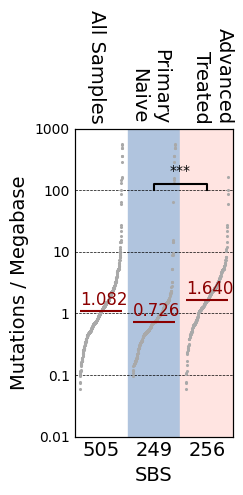

In [236]:
plotter.plotTMB_therapy(kzm611_mix[['Thr_State2', 'SBS']].copy(), sbs_pval, scale='genome',
                        color_dict=color_dict, order=['All Samples', 'Primary\nNaive', 'Advanced\nTreated'],
                        xaxis="SBS", yaxis = "Mutations / Megabase", Yrange=[0.01, 1000])
#plt.savefig(os.path.join(fig_out, 'Fig_2a1.pdf'), bbox_inches="tight")

Types
All Samples         -0.770030
Primary\nNaive      -0.857769
Advanced\nTreated   -0.686386
Name: log10BURDENpMB, dtype: float64
Yrange is a list


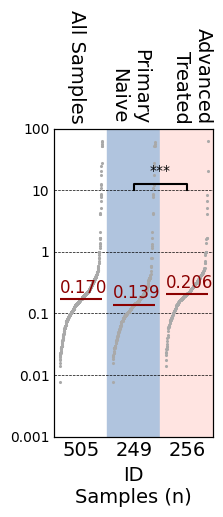

In [237]:
plotter.plotTMB_therapy(kzm611_mix[['Thr_State2', 'ID']].copy(), id_pval, scale='genome', color_dict=color_dict,
                        order=['All Samples', 'Primary\nNaive', 'Advanced\nTreated'],
                        xaxis="ID\nSamples (n)", yaxis = "", Yrange=[0.001, 100])

#plt.savefig(os.path.join(fig_out, 'Fig_2a2.pdf'), bbox_inches="tight")

Types
All Samples         -2.183241
Primary\nNaive      -2.348052
Advanced\nTreated   -1.859935
Name: log10BURDENpMB, dtype: float64
Yrange is a list


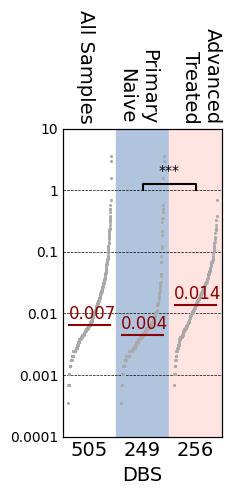

In [238]:
plotter.plotTMB_therapy(kzm611_mix[['Thr_State2', 'DBS']].copy(), dbs_pval, scale='genome', color_dict=color_dict,
                        order=['All Samples', 'Primary\nNaive', 'Advanced\nTreated'],
                        xaxis="DBS", yaxis = "", Yrange=[0.0001, 10])
#plt.savefig(os.path.join(fig_out, 'Fig_2a3.pdf'), bbox_inches="tight")

Types
All Samples         -1.859935
Primary\nNaive      -1.917927
Advanced\nTreated   -1.785325
Name: log10BURDENpMB, dtype: float64
Yrange is a list


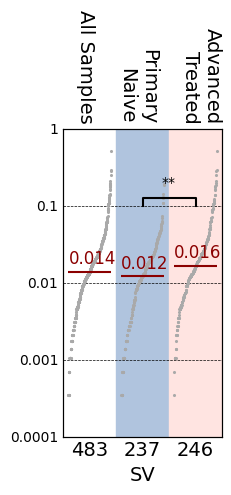

In [239]:
plotter.plotTMB_therapy(kzm611_mix[['Thr_State2', 'SV']].copy(), sv_pval, scale='genome',
                        color_dict=color_dict, order=['All Samples', 'Primary\nNaive', 'Advanced\nTreated'],
                        xaxis="SV", yaxis = "", Yrange=[0.0001, 1])
#plt.savefig(os.path.join(fig_out, 'Fig_2a4.pdf'), bbox_inches="tight")

Types
All Samples         -1.999597
Primary\nNaive      -2.081784
Advanced\nTreated   -1.870930
Name: log10BURDENpMB, dtype: float64
Yrange is a list


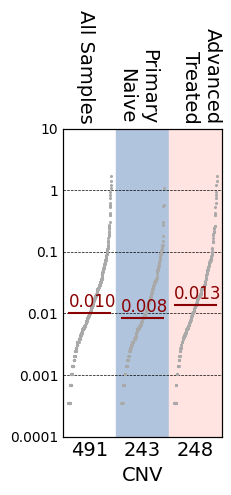

In [241]:
plotter.plotTMB_therapy(kzm611_mix[['Thr_State2', 'CN']].copy(), cnv_pval, scale='genome',
                        color_dict=color_dict, order=['All Samples', 'Primary\nNaive', 'Advanced\nTreated'],
                        xaxis="CNV", yaxis = "", Yrange=[0.0001, 10])
#plt.savefig(os.path.join(fig_out, 'Fig_2a5.pdf'), bbox_inches="tight")

-----------
## Panel b

In [ ]:
types10_md = kzm_tmb.copy()
types10_md['Therapy2'] = ['Naive' if x=='Primary-Naive' else 'Treated' for x in types10_md.Thr_State]
## Label aesthetics
types10_md['prepost'] = types10_md.Type + '::' + types10_md.Therapy2
types10_md = types10_md[~types10_md.prepost.isin(['HB::Treated', 'UNK::Naive', 'UNK::Treated'])]

## Get rid of any type with <5 samples either pre or post therapy
low_types = [x.split('::')[0] for x in types10_md.prepost.value_counts()[types10_md.prepost.value_counts()<5].index]
types10_md = types10_md[~types10_md.Type.isin(low_types)]
types10_md.head(2)

,Sex,Thr_State,Type,Age_days,Purity,SBS,DBS,ID,SV,CN,TMB,Sex_bin,State_bin,Therapy2,prepost
KiCS0006_274243,Female,Advanced-Treated,NBL,3528.0,0.74,3842.0,30.0,180.0,28.0,17.0,4052.0,0,1,Treated,NBL::Treated
KiCS0010_270645,Male,Advanced-Treated,OST,4326.0,0.94,6761.0,51.0,1288.0,180.0,147.0,8100.0,1,1,Treated,OST::Treated


In [ ]:
## calculate medians
median_diffs = []
for t in set([x.split('::')[0] for x  in types10_md.prepost.sort_values().unique()]):
    pret_median = np.median(np.log10(types10_md[types10_md.prepost==t+'::Naive'].SBS))
    post_median = np.median(np.log10(types10_md[types10_md.prepost==t+'::Treated'].SBS))
    median_diffs.append((t, post_median - pret_median))

## Sort df based on pre-post median increase
median_diffs_sorted = sorted(median_diffs, key=lambda x: x[1])
types10_sorted = [x+'::'+y for x in [i[0] for i in median_diffs_sorted] for y in ['Naive', 'Treated']]

In [ ]:
types10_md2 = types10_md.copy()
#types10_md2['Sex'] = [0 if x=='Female' else 1 for x in types10_md2.Sex]
types10_md2['Therapy_bin'] = [0 if x=='Naive' else 1 for x in types10_md2.Therapy2]
types10_md2.head(2)

,Sex,Thr_State,Type,Age_days,Purity,SBS,DBS,ID,SV,CN,TMB,Sex_bin,State_bin,Therapy2,prepost,Therapy_bin
KiCS0006_274243,Female,Advanced-Treated,NBL,3528.0,0.74,3842.0,30.0,180.0,28.0,17.0,4052.0,0,1,Treated,NBL::Treated,1
KiCS0010_270645,Male,Advanced-Treated,OST,4326.0,0.94,6761.0,51.0,1288.0,180.0,147.0,8100.0,1,1,Treated,OST::Treated,1


In [ ]:
def ranked_ancova_type(data, mut_type='SBS'):
    df = data[['Therapy_bin', 'Age_days', 'Sex_bin', 'Purity', mut_type]]
    df = df.dropna(axis=0)
    # Step 1: Rank the Dependent Variable
    df['RankedTMB'] = rankdata(df[mut_type])

    # Step 2: Regress Out Covariates (Age and Sex) from Ranked Data
    X = df[['Age_days', 'Sex_bin', 'Purity']]
    y = df['RankedTMB']

    # Fit linear regression on covariates
    reg = LinearRegression().fit(X, y)
    df['ResidualRanks'] = y - reg.predict(X)  # Residuals of ranked data

    # Step 3: Test Group Differences on Residuals
    group_0 = df[df['Therapy_bin'] == 0]['ResidualRanks']
    group_1 = df[df['Therapy_bin'] == 1]['ResidualRanks']

    # Perform an F-test on residual ranks (nonparametric equivalent of ANCOVA)
    f_stat, p_value = f_oneway(group_0, group_1)

    print(f"====== Ranked ANCOVA ======")
    print(f"====================== {mut_type}")
    print(f"F-Statistic: {f_stat}, P-Value: {p_value}")
    return p_value


In [ ]:
pval_dict = {x: ranked_ancova_type(types10_md2[types10_md2.Type==x], mut_type='SBS') for x in list(set([y.split('::')[0] for y in types10_sorted]))}
pval_dict

====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 0.013981056690276656, P-Value: 0.9074451721646897
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 8.71684096333836, P-Value: 0.005964136224211855
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 1.8954992917235625, P-Value: 0.18308481171763255
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 21.87705367214205, P-Value: 6.215326320856459e-05
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 7.271979746302602, P-Value: 0.01831016828488064
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 0.5162832798230218, P-Value: 0.476145883863628
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 5.758613636972101, P-Value: 0.028935917957457834
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 4.840892212222991, P-Value: 0.03201123682633907
====== Ranked ANCOVA ======
====================== SBS
F-Statistic:

{'AML': 0.9074451721646897,
 'OST': 0.005964136224211855,
 'ERMS': 0.18308481171763255,
 'BALL': 6.215326320856459e-05,
 'EPD': 0.01831016828488064,
 'HGG': 0.476145883863628,
 'ARMS': 0.028935917957457834,
 'NBL': 0.03201123682633907,
 'EWS': 0.521827927111638}

Yrange is a list
ARMS
OST
BALL
EPD
NBL


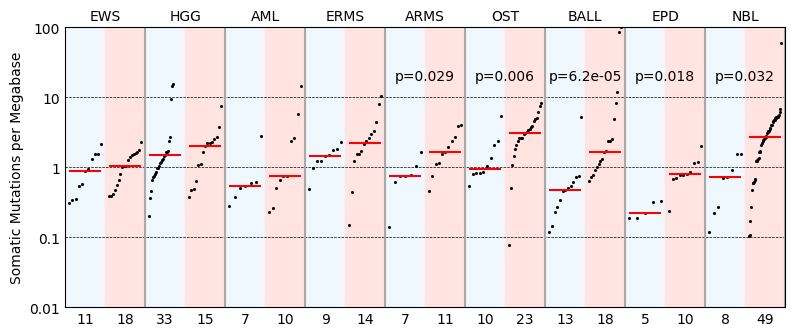

In [ ]:
#TMB_plotter.plotTMB_generic
plotter.plotTMB_type(types10_md[['prepost', 'SBS']].copy(), pval_dict, scale='genome', Yrange=[0.01, 100], order=types10_sorted)
plt.savefig(os.path.join(fig_out, 'Fig_2c.pdf'), bbox_inches="tight")

-----------
## Panel c

In [242]:
## Load the drivers df
KZM611_drivers_all = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_drivers_CosCGI.tsv'), sep='\t', index_col=0)
KZM611_drivers_low = KZM611_drivers_all[KZM611_drivers_all.Tumor_Sample_Barcode.isin(low_samples)]
KZM611_drivers_low.shape[0], KZM611_drivers_all.shape[0], KZM611_drivers_low.Tumor_Sample_Barcode.nunique(), KZM611_drivers_all.Tumor_Sample_Barcode.nunique()

(600, 1835, 314, 342)

In [243]:
KZM611_drivers_all.head(2)

,Hugo_Symbol,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,Tumor_VAF,amino_acid_change,cdna,Transcript,Tumor_Sample_Barcode,mid,uid,db,driver_type
0,KMT2C,KiCS,hg19,7,151970859,151970859,Missense_Mutation,SNP,C,T,0.039,p.G315S,c.G943A,NM_170606,KiCS0148_319486,7:151970859-151970859,KiCS0148_319486_7:151970859-151970859,COSMIC,exact
1,KRAS,KiCS,hg19,12,25398285,25398285,Missense_Mutation,SNP,C,A,0.439,p.G12C,c.G34T,NM_001369786,KiCS0221_18_2564,12:25398285-25398285,KiCS0221_18_2564_12:25398285-25398285,COSMIC;CGI,exact


In [247]:
## Get driver counts for all & low-burden tumors
drivers_counts_low = ut.get_drivers_table(KZM611_drivers_all, kzm611_md, 'Tumor_Sample_Barcode', burden='low')
drivers_counts_low.head()

,Zero,One,Two+
All,0.455806,0.292894,0.251300
Primary-Naive,0.487069,0.267241,0.245690
Primary-Treated,0.539326,0.280899,0.179775
Advanced-Naive,0.666667,0.166667,0.166667
Advanced-Treated,0.385246,0.327869,0.286885


Text(0, 0.5, 'Driver Mutations\n')

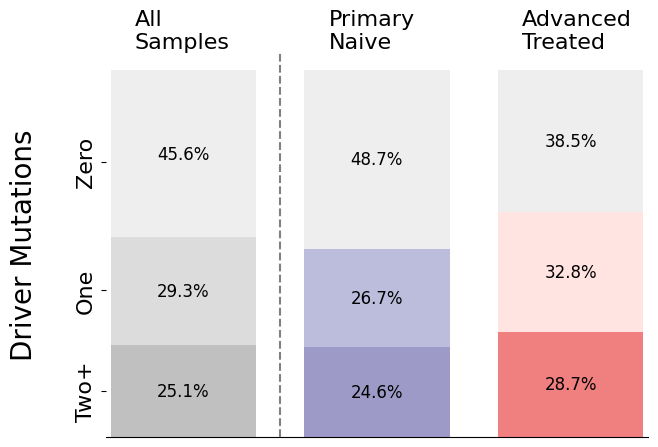

In [248]:
xlabels = ['All', 'Primary\nNaive', 'Advanced\nTreated']
ylabels = ['0', '20', '40', '60', '80', '100']
tab20c_cols = sns.color_palette("tab20c")
mycolors = tab20c_cols[-7:-4]#[::-1]

drivers_counts_low_subs = drivers_counts_low.loc[['All', 'Primary-Naive', 'Advanced-Treated']].copy()
drivers_counts_low_subs = drivers_counts_low_subs[['Two+', 'One', 'Zero']]

#fig, axes = plt.subplots(1,2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1]}, sharey=True)
fig, axes = plt.subplots(figsize=(7, 5))#, facecolor='#f4f0eb')

ax2 = drivers_counts_low_subs.plot.bar(stacked=True, color=mycolors, ax=axes, width=0.75, fontsize=16)
#ax2.set_xticks(ticks=[0,1,2], labels=xlabels)
ax2.set_xticks(ticks=[], labels=[])
ax2.set_yticks(ticks=[0.125,0.4,0.75], labels=['Two+', 'One', 'Zero'], rotation=90, verticalalignment='center')
ax2.axvline(x=0.5, ls='--', color='grey')
#ax2.axvline(x=2.5, ls='--', color='grey')

ann_y = 1.06
fs = 16
ax2.text(-0.25, ann_y, 'All\nSamples', fontsize=fs)
ax2.text(0.75, ann_y, 'Primary\nNaive', fontsize=fs)
ax2.text(1.75, ann_y, 'Advanced\nTreated', fontsize=fs)
#ax2.set_facecolor('#f4f0eb')

#plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', title='Drivers', fontsize=14)
plt.xlim(-0.4,2.4)

labels2 = [f'{i:.1%}' for i in drivers_counts_low_subs.to_numpy().flatten(order='F')]
for i, patch in enumerate(ax2.patches):
    x, y = patch.get_xy()
    x += patch.get_width() / 2
    y += patch.get_height() / 2
    if i in (6,7,8):
        patch.set_facecolor('#eeeeee')
    elif i == 3:
        patch.set_facecolor('gainsboro')
    elif i == 0:
        patch.set_facecolor('silver')
    elif i == 5:
        patch.set_facecolor('mistyrose')
    elif i == 2:
        patch.set_facecolor('lightcoral')
    
    ax2.annotate(labels2[i], (x, y), ha='center', va='center', c='black', fontsize=12)
ax2.spines[['right', 'top', 'left']].set_visible(False)
ax2.get_legend().remove()

plt.ylabel('Driver Mutations\n', fontsize=20)
#plt.savefig(os.path.join(fig_out, 'Fig_2b.pdf'), bbox_inches="tight")